<a href="https://colab.research.google.com/github/chonghan1111/myfirstproject/blob/main/BERT_personality_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Personality detection using BERT**

## Set the environment

Download the required dependencies

In [6]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 19.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement tensorflow==2.4.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow==2.4.0


In [6]:
!pip install -U tensorflow==2.12.0 keras==2.12.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 9.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Un

In [1]:
!pip install tensorflow-addons

Import necessary libraries

In [2]:
import pandas as pd
from transformers import TFBertModel, BertTokenizer
seed_value = 29
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
np.set_printoptions(precision=2)
import tensorflow as tf
tf.random.set_seed(seed_value)
import tensorflow_addons as tfa
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.callbacks import ModelCheckpoint
import re
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

Enable GPU processing

## Model training
I modeled personality detection on the **MBTI** dataset as a multilabel classification task.

In particular, the model treats each personality axis as a separate class, computing an independent probability for each one of them through a Bernuolli trial.

The model is based on **BERT** (HuggingFace Transfomers) and exploits the effectiveness of transfer learning from pre-trained language representation models.

In [4]:
N_AXIS = 4
MAX_SEQ_LEN = 128
BERT_NAME = 'bert-base-uncased'
'''
EMOTIONAL AXES:
Introversion (I) – Extroversion (E)
Intuition (N) – Sensing (S)
Thinking (T) – Feeling (F)
Judging (J) – Perceiving (P)
'''
axes = ["I-E","N-S","T-F","J-P"]
classes = {"I":0, "E":1, # axis 1
           "N":0,"S":1, # axis 2
           "T":0, "F":1, # axis 3
           "J":0,"P":1} # axis 4

### Preprocessing
The following operation are performed: text lowercasing, removing text in square brackets, links, words containing numbers, emoji and initial single quotes.

In [5]:
def text_preprocessing(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text.encode('ascii', 'ignore').decode('ascii')
    if text.startswith("'"):
        text = text[1:-1]
    return text

Load MBTI data, splitting it into train, val and test skipping the last incomplete batch.

In [6]:
# train_n=6624
# val_n=1024
# test_n=1024
data = pd.read_csv("/content/mbti_1.csv", on_bad_lines= 'skip')
data = data.sample(frac=1)
labels = []
print(data)

      type                                              posts
4420  INFP  i guess he's just preparing for wwIII, which w...
7570  ENTJ  'More like whenever we start talking about any...
2807  INFP  'I have this really strange fear of shiny jewe...
463   ISTP  'Exactly!   :cheers2:|||Same here! So curious....
3060  INFJ  'May I pop in?  I've been struggling with perf...
...    ...                                                ...
920   INFP  'Those are excellent examples and explanation,...
864   INTP  'I was thinking the same.|||we do that sometim...
808   ISTP  'Associate in Professional Flight Technology||...
6380  INFJ  'I just love this...  https://www.youtube.com/...
8149  INTJ  'I haven't posted here in a while.  Forgive me...

[8675 rows x 2 columns]


In [8]:
print(len(data))
sampling_data = data.sample(frac=0.1)

train_n=len(sampling_data.sample(frac=0.7))
val_n=len(sampling_data.sample(frac=0.15))
test_n=len(sampling_data.sample(frac=0.15))
total = train_n+val_n+test_n

print(f"{sampling_data} \n train  : {train_n} \n val    : {val_n} \n test   : {test_n} \n total  : {total}")

8675
      type                                              posts
1452  ENFP  'She seems ESFP-ish to me. It's hard with actr...
5572  INFP  'Yes we are handicapped, useless and regular l...
116   ENTP  INFPs care about authenticity, not INFJs. Are ...
4800  INFP  Yo, it is quite funny the standards and such. ...
5038  INTJ  'I think you need to meet my Wife... or maybe ...
...    ...                                                ...
6277  ISTP  'Fuck me, climbing out of this hole I dug myse...
5383  INFP  And some -many in fact- extroverts regard us a...
3833  INFP  'Let's see 1)god 2)piano 3)my band 4)singing 5...
6294  INTJ  'Istj :laughing: At least upon first glance. C...
1978  ENTP  Just to make things clear, my ex was 100% an I...

[868 rows x 2 columns] 
 train  : 608 
 val    : 130 
 test   : 130 
 total  : 868


In [9]:
for personality in data["type"]:
    pers_vect = []
    for p in personality:
        pers_vect.append(classes[p])
    labels.append(pers_vect)
sentences = data["posts"].apply(str).apply(lambda x: text_preprocessing(x))
labels = np.array(labels, dtype="float32")
train_sentences = sentences[:train_n]
y_train = labels[:train_n]
val_sentences = sentences[train_n:train_n+val_n]
y_val = labels[train_n:train_n+val_n]
test_sentences = sentences[train_n+val_n:train_n+val_n+test_n]
y_test = labels[train_n+val_n:train_n+val_n+test_n]

Encode sentences following the BERT specifications

In [10]:
def prepare_bert_input(sentences, seq_len, bert_name):
    tokenizer = BertTokenizer.from_pretrained(bert_name)
    encodings = tokenizer(sentences.tolist(), truncation=True, padding='max_length',
                                max_length=seq_len)
    input = [np.array(encodings["input_ids"]), np.array(encodings["attention_mask"]),
               np.array(encodings["token_type_ids"])]
    return input

In [11]:
X_train = prepare_bert_input(train_sentences, MAX_SEQ_LEN, BERT_NAME)
X_val = prepare_bert_input(val_sentences, MAX_SEQ_LEN, BERT_NAME)
X_test = prepare_bert_input(test_sentences, MAX_SEQ_LEN, BERT_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Model architecture

Encoded input is processed by the BERT model. Then, a Global Average Pooling on the sequence of all hidden states is used in order to get a concise representation of the whole sentence. Finally the output sigmoid layer compute an independent probability for each personality axis.

In [12]:
input_ids = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='input_ids')
input_mask = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='attention_mask')
input_type = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='token_type_ids')
inputs = [input_ids, input_mask, input_type]
bert = TFBertModel.from_pretrained(BERT_NAME)
bert_outputs = bert(inputs)
last_hidden_states = bert_outputs.last_hidden_state
avg = layers.GlobalAveragePooling1D()(last_hidden_states)
output = layers.Dense(N_AXIS, activation="sigmoid")(avg)
model = keras.Model(inputs=inputs, outputs=output)
model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

### End-to-end fine-tuning

The model is fully fine-tuned with a small learning rate to readapt the pre-trained features to work with our downstream task. I used a binary cross-entropy loss as the prediction for each personality axis is modeled like a single Bernoulli trial, estimating the probability through a sigmoid activation. Moreover I chose the Rectified version of ADAM (RAdam) as the optimizer for the training process. Lastly, I used the area under the Receiver Operating Characteristic curve (ROC AUC), and binary accuracy as the main metrics for validation and testing.

In [13]:
max_epochs = 7
batch_size = 32
opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)
loss = keras.losses.BinaryCrossentropy()
best_weights_file = "weights.h5"
auc = keras.metrics.AUC(multi_label=True, curve="ROC")
m_ckpt = ModelCheckpoint(best_weights_file, monitor='val_'+auc.name, mode='max', verbose=2,
                          save_weights_only=True, save_best_only=True)
model.compile(loss=loss, optimizer=opt, metrics=[auc, keras.metrics.BinaryAccuracy()])
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=max_epochs,
    batch_size=batch_size,
    callbacks=[m_ckpt],
    verbose=2
)

Epoch 1/7



Epoch 1: val_auc improved from -inf to 0.47881, saving model to weights.h5
19/19 - 1092s - loss: 0.6291 - auc: 0.5163 - binary_accuracy: 0.6789 - val_loss: 0.5804 - val_auc: 0.4788 - val_binary_accuracy: 0.7154 - 1092s/epoch - 57s/step
Epoch 2/7

Epoch 2: val_auc improved from 0.47881 to 0.48518, saving model to weights.h5
19/19 - 1073s - loss: 0.5705 - auc: 0.5421 - binary_accuracy: 0.7089 - val_loss: 0.5532 - val_auc: 0.4852 - val_binary_accuracy: 0.7212 - 1073s/epoch - 56s/step
Epoch 3/7

Epoch 3: val_auc improved from 0.48518 to 0.50938, saving model to weights.h5
19/19 - 1033s - loss: 0.5631 - auc: 0.5792 - binary_accuracy: 0.7089 - val_loss: 0.5522 - val_auc: 0.5094 - val_binary_accuracy: 0.7173 - 1033s/epoch - 54s/step
Epoch 4/7

Epoch 4: val_auc improved from 0.50938 to 0.51062, saving model to weights.h5
19/19 - 1053s - loss: 0.5545 - auc: 0.6274 - binary_accuracy: 0.7286 - val_loss: 0.5522 - val_auc: 0.5106 - val_binary_accuracy: 0.7250 - 1053s/epoch - 55s/step
Epoch 5/7

Ep

## Results evaluation

Evaluate the model on the test set.

In [14]:
loss = keras.losses.BinaryCrossentropy()
best_weights_file = "weights.h5"
model.load_weights(best_weights_file)
opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)
model.compile(loss=loss, optimizer=opt, metrics=[keras.metrics.AUC(multi_label=True, curve="ROC"),
                                                  keras.metrics.BinaryAccuracy()])
predictions = model.predict(X_test)
model.evaluate(X_test, y_test, batch_size=32)

5/5 [==============================] - 71s 12s/step - loss: 0.5558 - auc_1: 0.6073 - binary_accuracy: 0.7135


[0.5557919144630432, 0.6073111295700073, 0.7134615182876587]

Plot ROC AUC for each personality axis.

In [15]:
def plot_roc_auc(y_test, y_score, classes):
    assert len(classes) > 1, "len classes must be > 1"
    plt.figure()
    if len(classes) > 2:  # multi-label
        # Compute ROC curve and ROC area for each class
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc))
        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        # Plot ROC curve
        plt.plot(fpr, tpr, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc))
    else:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(y_test, y_score, classes):
    assert len(classes) > 1, "len classes must be > 1"
    plt.figure()

    # Check if y_test and y_score are 2D
    if y_test.ndim == 1 and y_score.ndim == 1:
        # If both are 1D, handle as binary classification
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    elif y_test.ndim == 2 and y_score.ndim == 2 and y_test.shape[1] == len(classes) and y_score.shape[1] == len(classes):
        # If both are 2D and have expected number of columns, handle as multi-label
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc))
        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        # Plot ROC curve
        plt.plot(fpr, tpr, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc))
    else:
        raise ValueError("y_test and y_score have incompatible shapes. "
                         "For binary classification, both should be 1D. "
                         "For multi-label classification, both should be 2D "
                         "and have the same number of columns as classes.")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

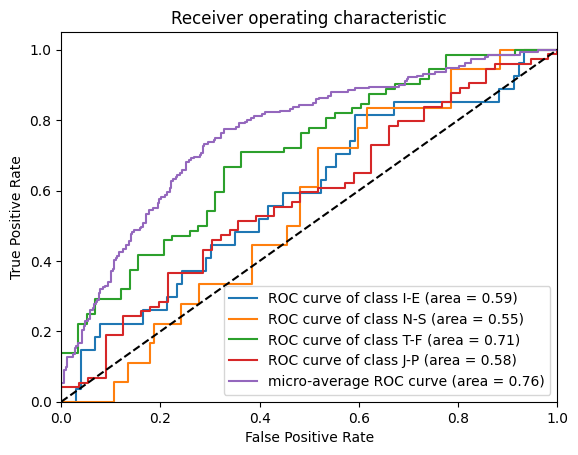

In [18]:
plot_roc_auc(y_test, predictions, axes)

As a final step, I tested the model with a simple sentence for finding out my personality.

In [20]:
s1 = "I love playing basketball with my friend."
sentences = np.asarray([s1])
enc_sentences = prepare_bert_input(sentences, MAX_SEQ_LEN, BERT_NAME)
predictions = model.predict(enc_sentences)
for sentence, pred in zip(sentences, predictions):
    pred_axis = []
    mask = (pred > 0.5).astype(bool)
    for i in range(len(mask)):
        if mask[i]:
            pred_axis.append(axes[i][2])
        else:
            pred_axis.append(axes[i][0])
    print('-- comment: '+sentence.replace("\n", "").strip() +
          '\n-- personality: '+str(pred_axis) +
          '\n-- scores:'+str(pred))

1/1 [==============================] - 1s 892ms/step
-- comment: I love playing basketball with my friend.
-- personality: ['I', 'N', 'F', 'P']
-- scores:[0.49 0.31 0.8  0.57]
